## 1. Импорты библиотек, инициализация глобальных переменных

### 1.1 Импорт библиотек

In [1]:
# youtube api
import googleapiclient.discovery
import time
import pandas as pd
import collections
# api для субтитров
from youtube_transcript_api import YouTubeTranscriptApi

#text
import re
import string
import pymorphy2
import dirt_tongue
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk import word_tokenize, ngrams
import nltk
nltk.download('punkt')
nltk.download('stopwords')

#plt
import plotly.express as px
import matplotlib.pyplot as plt

%matplotlib inline
from tqdm.notebook import tqdm
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.2 Инициализация глобальных переменных

In [2]:
API_SERVICE_NAME = "youtube"
API_VERSION = "v3"
# Ваш API KEY from Google Cloud
API_KEY = ""
# id канала, с которого нужно собрать информацию о видео
# Для примера беру канал вДудь
CHANNEL_ID = 'UCMCgOm8GZkHp8zJ6l7_hIuA'
youtube = googleapiclient.discovery.build(API_SERVICE_NAME, API_VERSION, developerKey = API_KEY)

## 2 Парсинг и предобработка данных

### 2.1 Парсинг статистических данных о видео

In [3]:
r = youtube.channels().list(
       part = "contentDetails",
       id = CHANNEL_ID,
       access_token=API_KEY
 )
resp = r.execute()
video_data = {}
id_playlist = resp['items'][0]['contentDetails']['relatedPlaylists']['uploads']  
id_playlist

'UUMCgOm8GZkHp8zJ6l7_hIuA'

In [4]:
# Удобнее всего получить данные о всех видео, собрав все видео в один плейлист
# За один запрос можно получить информацию о 5 видео, на момент создания проекта на канале находится 164 видео
# Получив первые 5 видео, нужно снова отправить запрос на получение следующих 5 видео
# Делаем это, указав свойство 'nextPageToken'
video_data = {}
next_token = ''
while(True):     
    time.sleep(0.2)
    r = youtube.playlistItems().list(
    part="contentDetails",
    playlistId = id_playlist,
    access_token=API_KEY,
    pageToken = next_token
    )
    tt = r.execute()
    resp = r.execute()
    for i in resp['items']:
        id_videos = i['contentDetails']['videoId']
        r = youtube.videos().list(
        part="snippet, statistics",
        id=id_videos,               
        access_token=API_KEY
        )
        resp1 = r.execute()       
        video_data[id_videos] = [CHANNEL_ID,
                           resp1['items'][0]['snippet']['publishedAt'],
                           resp1['items'][0]['snippet']['title'],
                           resp1['items'][0]['snippet']['description'],
                           resp1['items'][0]['statistics']['viewCount'],
                           resp1['items'][0]['statistics']['likeCount'],
                           resp1['items'][0]['statistics']['commentCount']
        ]
    try:
        next_token = resp['nextPageToken']
    except:
        break

In [5]:
# Из собранных данных создаем датафрейм
d = {'id': [x for x in video_data],
      'channel_id': [video_data[x][0] for x in video_data],
      'published_at': [video_data[x][1] for x in video_data],
      'title': [video_data[x][2] for x in video_data],
      'description': [video_data[x][3] for x in video_data],
      'viewCount': [video_data[x][4] for x in video_data],
      'likeCount': [video_data[x][5] for x in video_data],
      'commentCount': [video_data[x][6] for x in video_data]
   }
df = pd.DataFrame(d)
df.head(1)

,id,channel_id,published_at,title,description,viewCount,likeCount,commentCount
0,PyE3LT0iLSM,UCMCgOm8GZkHp8zJ6l7_hIuA,2023-03-17T07:26:16Z,Кузнецов – война и Фантастические твари / Kuzn...,Анкета для регистрации во FreeDa: https://free...,6222143,157155,20970


In [6]:
# Конвертируем формат даты ('PT2H12M51S') в секунды
def convert_YouTube_duration_to_seconds(duration):
   day_time = duration.split('T')
   day_duration = day_time[0].replace('P', '')
   day_list = day_duration.split('D')
   if len(day_list) == 2:
      day = int(day_list[0]) * 60 * 60 * 24
      day_list = day_list[1]
   else:
      day = 0
      day_list = day_list[0]
   hour_list = day_time[1].split('H')
   if len(hour_list) == 2:
      hour = int(hour_list[0]) * 60 * 60
      hour_list = hour_list[1]
   else:
      hour = 0
      hour_list = hour_list[0]
   minute_list = hour_list.split('M')
   if len(minute_list) == 2:
      minute = int(minute_list[0]) * 60
      minute_list = minute_list[1]
   else:
      minute = 0
      minute_list = minute_list[0]
   second_list = minute_list.split('S')
   if len(second_list) == 2:
      second = int(second_list[0])
   else:
      second = 0
   return day + hour + minute + second

In [7]:
# Извлекаем длительность всех видео в секундах
videos = df['id'].tolist()
df['duration'] = 0
for i in tqdm(range(df.shape[0])):
    q = youtube.videos().list(
        part = 'contentDetails',
        id=videos[i],               
        access_token=API_KEY
        ).execute()
    df['duration'][i] = q['items'][0]['contentDetails']['duration']
    df['duration'][i] = convert_YouTube_duration_to_seconds(df['duration'][i])
df[['duration']]

  0%|          | 0/166 [00:00<?, ?it/s]

,duration
0,10834
1,6893
2,14331
3,10306
4,7812
...,...
161,2945
162,2889
163,2865
164,2860


In [8]:
# Делаем удобный формат колонок
df = df[['title', 'id', 'published_at', 'description', 'viewCount', 'likeCount', 'commentCount', 'duration']]
df.head(1)

,title,id,published_at,description,viewCount,likeCount,commentCount,duration
0,Кузнецов – война и Фантастические твари / Kuzn...,PyE3LT0iLSM,2023-03-17T07:26:16Z,Анкета для регистрации во FreeDa: https://free...,6222143,157155,20970,10834


### 2.2 Предобработка статистических данных о видео

In [9]:
df.dtypes
# Меняем тип данных числовых колонок, так как после парсинга с ютуба все значения формата string(object),
# в данном случае необходимо поменять типы колонкам viewCount, likeCount, commentCount, duration на целые числа(int)
df = df.astype({'viewCount': int, 'likeCount': int, 'commentCount': int, 'duration': int})
df.dtypes

title           object
id              object
published_at    object
description     object
viewCount        int64
likeCount        int64
commentCount     int64
duration         int64
dtype: object

In [10]:
df.head(1)

,title,id,published_at,description,viewCount,likeCount,commentCount,duration
0,Кузнецов – война и Фантастические твари / Kuzn...,PyE3LT0iLSM,2023-03-17T07:26:16Z,Анкета для регистрации во FreeDa: https://free...,6222143,157155,20970,10834


* **title** - название видео<br>
* **id** - id видео<br>
* **published_at** - время и дата публикации видео<br>
* **description** - описание видео<br>
* **viewCount** - количество просмотров<br>
* **likeCount** - количество лайков<br>
* **commentCount** - количество комментариев<br>
* **duration** - длительность видео в секундах<br>

### 2.3 Парсинг субтитров к видео

In [11]:
# Создаем новый датафрейм для работы с текстом(субтитрами)
# Приоритет выбора субтитров: созданные вручную, в случае отсутствия - автоматические
# Если субтитров нет - пропускаем
df_text = pd.DataFrame()
df_text['title'] = df['title']
df_text['text'] = ''
df_text['dirt_min'] =''
df_text['dirt'] =''
df_text['total'] =''
df_text['uniq'] =''
df_text['percent'] =''
try:
    for i in tqdm(range(df.shape[0])):
        transcript_list = YouTubeTranscriptApi.list_transcripts(df['id'][i])
        df_text['text'][i] = transcript_list.find_transcript(['ru']).fetch()
except:
    pass

  0%|          | 0/166 [00:00<?, ?it/s]

In [12]:
df_text.head()

,title,text,dirt_min,dirt,total,uniq,percent
0,Кузнецов – война и Фантастические твари / Kuzn...,"[{'text': '[музыка]', 'start': 2.29, 'duration...",,,,,
1,Чиков – простые вопросы о законах / Chikov – s...,"[{'text': '25.000000', 'start': 0.04, 'duratio...",,,,,
2,Певчих – что коррупция сделала с Россией / Pev...,"[{'text': '25.000000', 'start': 0.04, 'duratio...",,,,,
3,"Разговор с тем, кто поддерживает армию России ...","[{'text': '25.000000', 'start': 0.04, 'duratio...",,,,,
4,Парфенов – что происходит с Россией / Parfenov...,"[{'text': '25.000000', 'start': 0.04, 'duratio...",,,,,


### 2.4 Предобработка субтитров к видео

In [13]:
morph = pymorphy2.MorphAnalyzer()
stopwords_list = stopwords.words('russian')
string.punctuation += '—'
# Очищаем текст от символов и ненужных слов
def clean_string(text):
    text = re.split(' |:|\.|\(|\)|,|"|;|/|\n|\t|-|\?|\[|\]|!', text)
    text = ' '.join([word for word in text if word not in string.punctuation])
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords_list])
    return text
# С помощью pymorphy2 приводим слова к начальной форме
def string_to_normal_form(string):
    string_lst = string.split()
    for i in range(len(string_lst)):
        string_lst[i] = morph.parse(string_lst[i])[0].normal_form
        if (string_lst[i] == 'аду'):
            string_lst[i] = 'ад'
        if (string_lst[i] == 'рая'):
            string_lst[i] = 'рай'
    string = ' '.join(string_lst)
    return string

In [14]:
# Для некоторых видеороликов субтитры отключены/недоступны, поэтому эти видео пропускаем
df_text = df_text[df_text.text != '']

In [15]:
# Собираем все субтитры за видео в строку и очиащем текст
for j in range(df_text.shape[0]):
    s = ''
    for i in range(len(df_text['text'][j])):
        s = s + string_to_normal_form(clean_string(df_text['text'][j][i]['text'])) + ' '
    df_text['text'][j] = s
    

In [16]:
df_text.dtypes
df_text['duration'] = df.loc[:,['duration']]
df_text.head(1)

,title,text,dirt_min,dirt,total,uniq,percent,duration
0,Кузнецов – война и Фантастические твари / Kuzn...,музыка музыка муж часть семья украина это част...,,,,,,10834


* **title** - название видео<br>
* **text** - текст видео из субтитров<br>
* **dirt_min** - количество нецензурных слов в минуту<br>
* **dirt** - общее количество нецензурных слов<br>
* **duration** - длительность видео в секундах<br>
* **total** - всего слов в видео<br>
* **uniq** - число уникальных слов в видео<br>
* **percent** - отношение уникальных слов ко всем<br>

## 3 Работа с данными

In [17]:
# Рассчитываем для каждого видео количество слов в нем, количество уникальных слов и процент уникальных слов относительно общего количества
titles = []
total = []
uniq = []
percent = []

for title, text in tqdm(zip(df_text.title, df_text.text)):
    titles.append(title)
    total.append(len(text.split()))
    uniq.append(len(set(text.split())))
    percent.append(round(len(set(text.split())) / len(text.split()), 2) * 100)
df_text.loc[:, ['total']] = total
df_text.loc[:, ['uniq']] = uniq
df_text.loc[:, ['percent']] = percent

0it [00:00, ?it/s]

In [18]:
df_text.head(1)

,title,text,dirt_min,dirt,total,uniq,percent,duration
0,Кузнецов – война и Фантастические твари / Kuzn...,музыка музыка муж часть семья украина это част...,,,13951,3112,22.0,10834


In [19]:
# Проверяем слова в видео на наличие нецензурной лексики и считаем ее количество
detector = dirt_tongue.is_dirt()
for j in tqdm(range(df_text.shape[0])):
    i = 0
    for elem in df_text['text'][j].split():
        if detector(elem):
            i+=1
    df_text['dirt'][j] = i
    df_text['dirt_min'][j] = i/df_text['duration'][j]*60
df_text = df_text.astype({'dirt_min':float, 'duration' : int, 'dirt': int})

  0%|          | 0/155 [00:00<?, ?it/s]

## 4 Визуализация

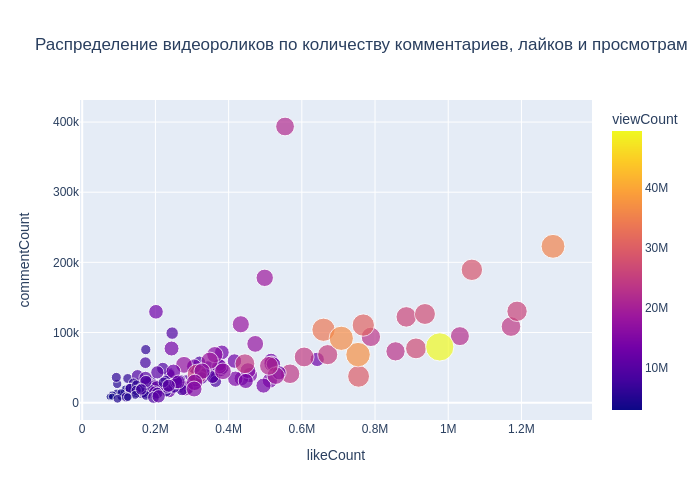

In [20]:
fig = px.scatter(df, x="likeCount", y="commentCount", color="viewCount", 
                 hover_name="title", size = 'viewCount', 
                 title = 'Распределение видеороликов по количеству комментариев, лайков и просмотрам')
fig.show("png")

0it [00:00, ?it/s]

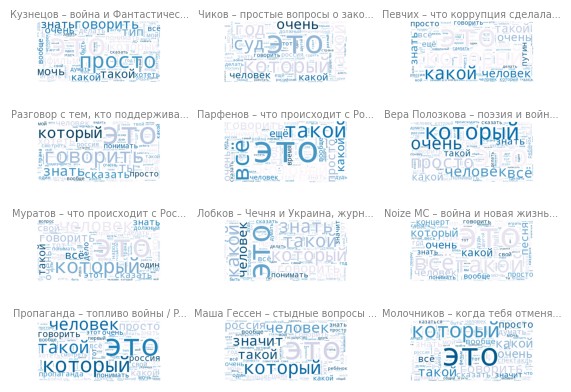

In [21]:
# Создаем облако слов для последних 12 видео
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.subplots_adjust(wspace=0.5, hspace=0.4)
i = 1
for title, text in tqdm(zip(df_text.head(12).title, df_text.head(12).text)):
    tokens = word_tokenize(text)
    text_raw = " ".join(tokens)
    wordcloud = WordCloud(colormap='PuBu', background_color='white', contour_width=10).generate(text_raw)
    plt.subplot(4, 3, i, label=title,frame_on=True)
    plt.tick_params(labelsize=10)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f'{title[:30]}...',fontdict={'fontsize':7,'color':'grey'},y=0.93)
    plt.tick_params(labelsize=10)
    i += 1

In [22]:
# Топ-5 видео с наименьшим содержанием нецензурной лексики

df_text.sort_values(by='dirt_min', ascending = False).tail(1)

,title,text,dirt_min,dirt,total,uniq,percent,duration
132,"Познер – цензура, страх и Путин /Vladimir Pozn...",25 000000 уверить найти «эльдорадо» хороший це...,0.128096,10,5690,1932,34.0,4684


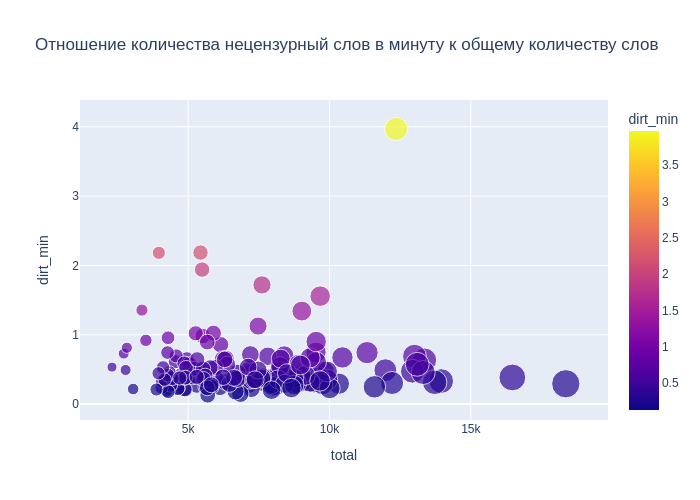

In [23]:
fig = px.scatter(df_text, x="total", y="dirt_min", color="dirt_min", 
                 hover_name="title", size = 'total', 
                 title = 'Отношение количества нецензурный слов в минуту к общему количеству слов')
fig.show("png")

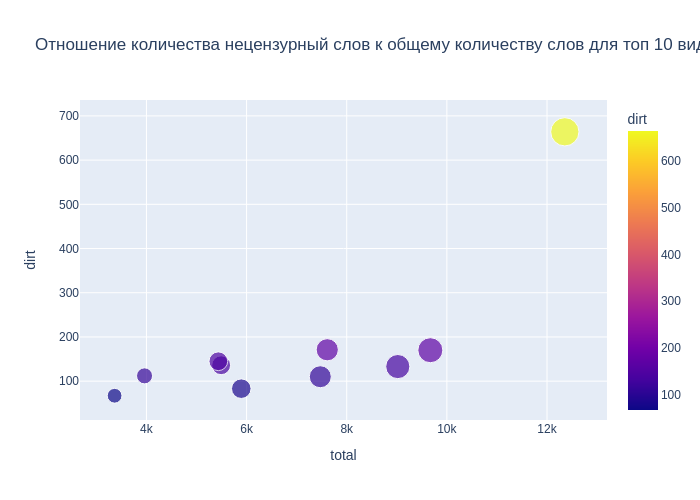

In [24]:
fig = px.scatter(df_text.sort_values(by='dirt_min').tail(10), x="total", y="dirt", color="dirt", 
                 hover_name="title", size = 'total', 
                 title = 'Отношение количества нецензурный слов к общему количеству слов для топ 10 видео с наибольшим содержанием нецензурной лексики')
fig.show("png")

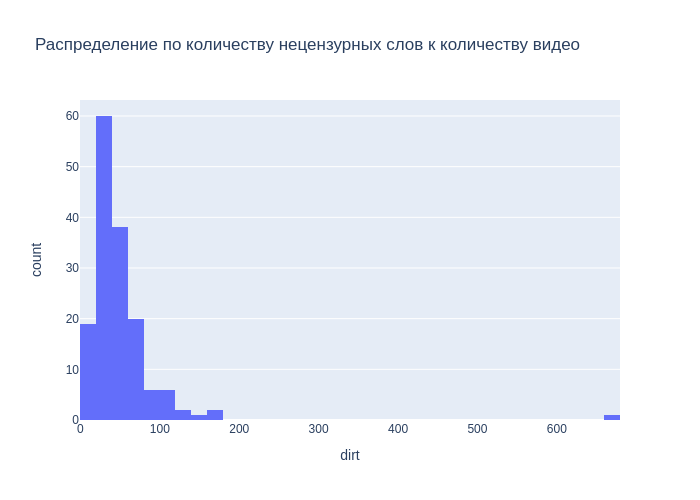

In [25]:
fig = px.histogram(df_text, x="dirt", title = 'Распределение по количеству нецензурных слов к количеству видео')
fig.show("png")